In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

canterbury_data = pd.read_csv('processed_canterbury_housing_features.csv')
canterbury_data['Date'] = pd.to_datetime(canterbury_data['Date'])

print(canterbury_data.head())
print(canterbury_data.info())

        Date   Price      Region  Month  Season  Spring  Summer  Winter  Year  \
0 2018-01-01  500529  Canterbury      1  Summer   False    True   False  2018   
1 2018-01-08  500869  Canterbury      1  Summer   False    True   False  2018   
2 2018-01-15  500794  Canterbury      1  Summer   False    True   False  2018   
3 2018-01-22  500910  Canterbury      1  Summer   False    True   False  2018   
4 2018-01-29  500729  Canterbury      1  Summer   False    True   False  2018   

   Months_Since_2000  
0                217  
1                217  
2                217  
3                217  
4                217  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               294 non-null    datetime64[ns]
 1   Price              294 non-null    int64         
 2   Region             294 non-null    object    

Featuyre engineering - creating dummy varaiblse 

In [2]:
canterbury_data['Month'] = canterbury_data['Date'].dt.month
canterbury_data['Year'] = canterbury_data['Date'].dt.year
canterbury_data['DayOfWeek'] = canterbury_data['Date'].dt.dayofweek

canterbury_data['Price_Lag_1'] = canterbury_data['Price'].shift(1)
canterbury_data['Price_Lag_7'] = canterbury_data['Price'].shift(7)

canterbury_data['Price_Rolling_Mean_7'] = canterbury_data['Price'].rolling(window=7).mean()
canterbury_data['Price_Rolling_Mean_30'] = canterbury_data['Price'].rolling(window=30).mean()

canterbury_data = canterbury_data.dropna()

features = ['Year', 'Month', 'DayOfWeek', 'Spring', 'Summer', 'Winter', 
            'Months_Since_2000', 'Price_Lag_1', 'Price_Lag_7', 
            'Price_Rolling_Mean_7', 'Price_Rolling_Mean_30']
X = canterbury_data[features]
y = canterbury_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features used:", features)
print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Features used: ['Year', 'Month', 'DayOfWeek', 'Spring', 'Summer', 'Winter', 'Months_Since_2000', 'Price_Lag_1', 'Price_Lag_7', 'Price_Rolling_Mean_7', 'Price_Rolling_Mean_30']
Shape of training data: (212, 11)
Shape of testing data: (53, 11)


In [3]:
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Average cross-validation RMSE: {cv_rmse.mean()}")

Mean Squared Error: 3950815.3265772406
Root Mean Squared Error: 1987.665798512728
R-squared Score: 0.9996741414070129
Cross-validation RMSE scores: [3431.00123032 2530.03512219 4379.11433357 2759.80417134 4529.14549754]
Average cross-validation RMSE: 3525.8200709909534


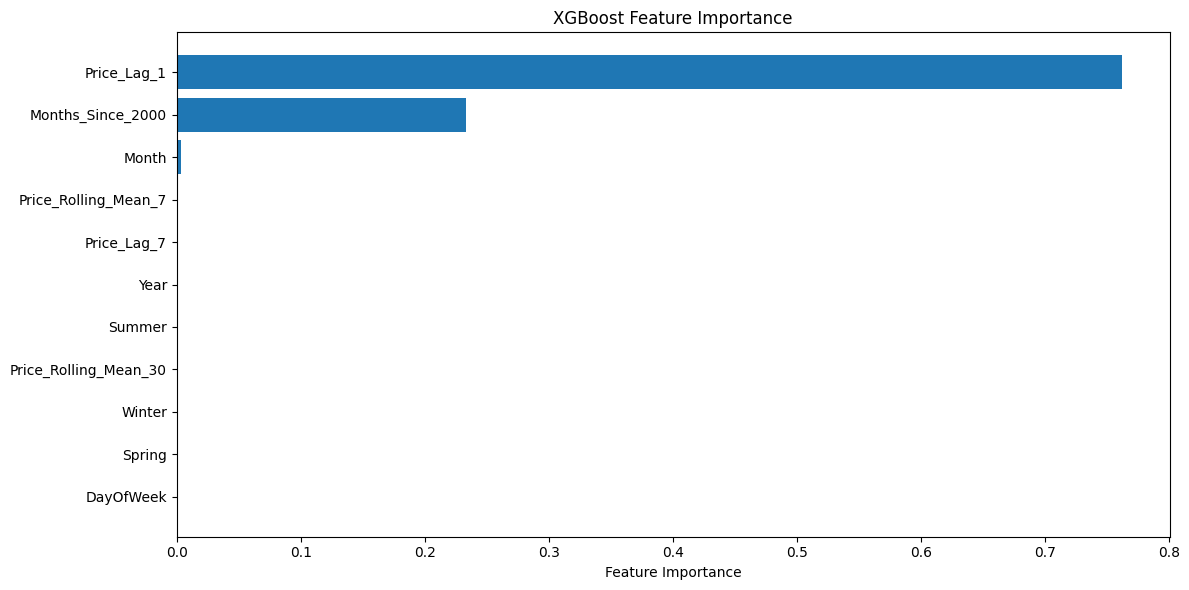

In [4]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(features)[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

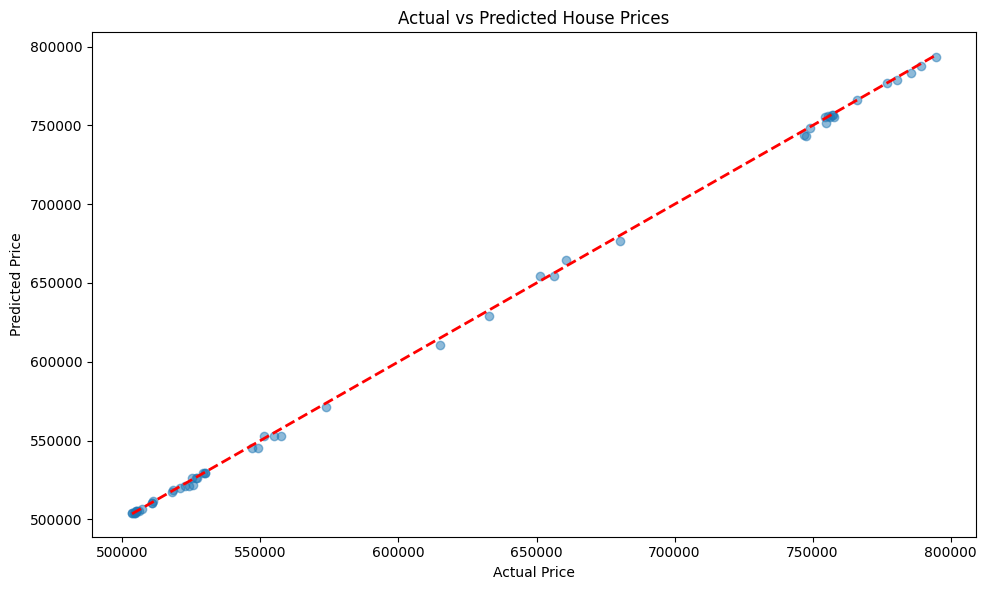

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.tight_layout()
plt.show()

        Date  Predicted_Price
0 2023-08-31      755963.5625
1 2023-09-30      755964.6875
2 2023-10-31      756677.7500
3 2023-11-30      756518.4375
4 2023-12-31      756510.1875
5 2024-01-31      757060.3125


C:\Users\arawa\AppData\Local\Temp\ipykernel_29952\457531997.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=6, freq='M')


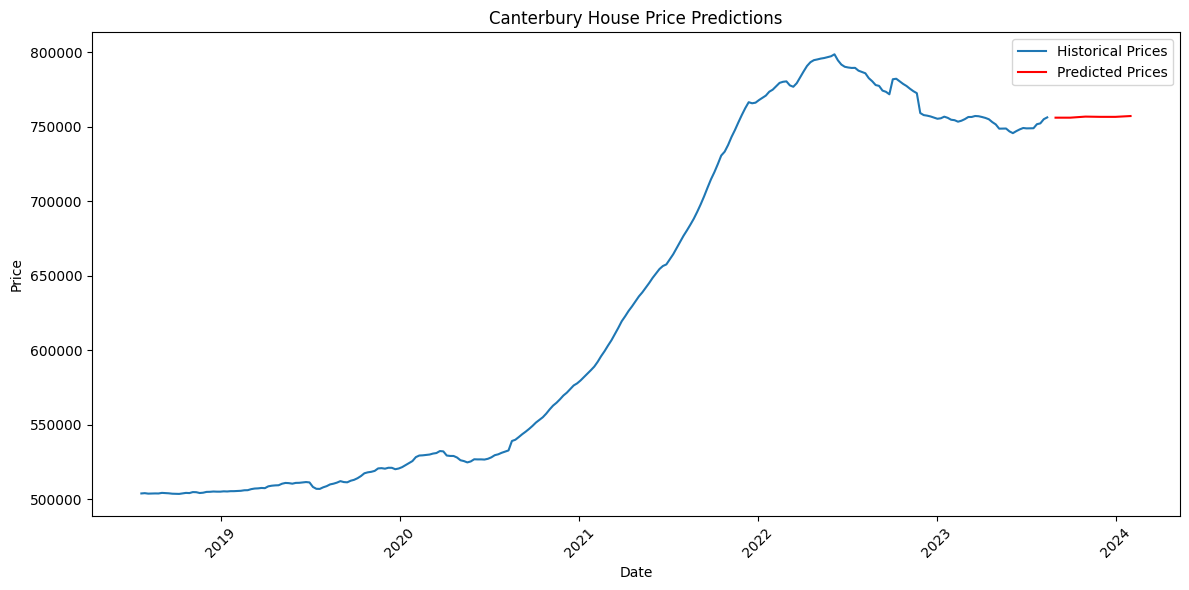

In [7]:
# next few months predictions but shouuld I do whole year/quartily or specific dates
last_date = canterbury_data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=6, freq='M')

last_known_price = canterbury_data['Price'].iloc[-1]
last_known_lag_7 = canterbury_data['Price_Lag_7'].iloc[-1]
last_known_rolling_mean_7 = canterbury_data['Price_Rolling_Mean_7'].iloc[-1]
last_known_rolling_mean_30 = canterbury_data['Price_Rolling_Mean_30'].iloc[-1]

future_predictions = []

for future_date in future_dates:
    future_features = pd.DataFrame({
        'Year': [future_date.year],
        'Month': [future_date.month],
        'DayOfWeek': [future_date.dayofweek],
        'Spring': [1 if future_date.month in [9, 10, 11] else 0],
        'Summer': [1 if future_date.month in [12, 1, 2] else 0],
        'Winter': [1 if future_date.month in [6, 7, 8] else 0],
        'Months_Since_2000': [(future_date.year - 2000) * 12 + future_date.month],
        'Price_Lag_1': [last_known_price],
        'Price_Lag_7': [last_known_lag_7],
        'Price_Rolling_Mean_7': [last_known_rolling_mean_7],
        'Price_Rolling_Mean_30': [last_known_rolling_mean_30]
    })
    
    future_features_scaled = scaler.transform(future_features)
    predicted_price = model.predict(future_features_scaled)[0]
    future_predictions.append(predicted_price)
    
    last_known_price = predicted_price

future_pred_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions
})

print(future_pred_df)

plt.figure(figsize=(12, 6))
plt.plot(canterbury_data['Date'], canterbury_data['Price'], label='Historical Prices')
plt.plot(future_pred_df['Date'], future_pred_df['Predicted_Price'], label='Predicted Prices', color='red')
plt.title('Canterbury House Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()